<a href="https://colab.research.google.com/github/jarinari/Algorithmic-Trading-Plugins/blob/master/insiders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

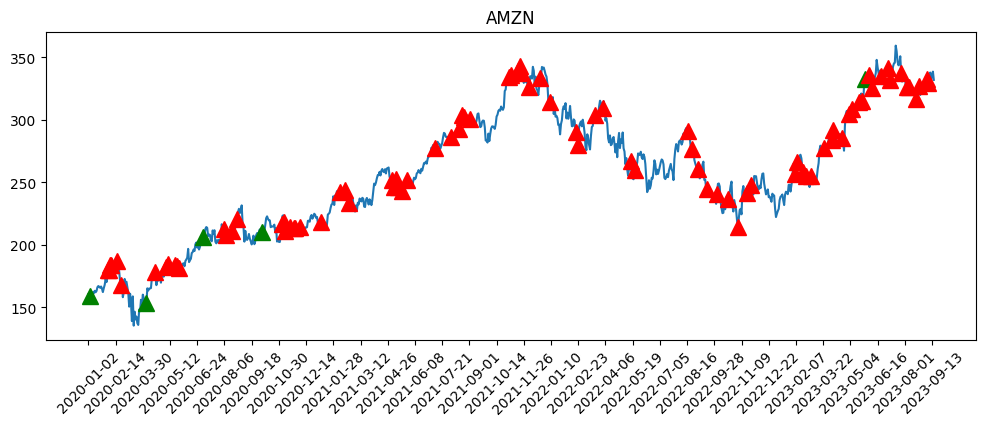

In [ ]:
#ELECCIÓN DE LA ACCIÓN
ticker='AMZN'

#OBTENCIÓN DE LOS DATOS DE INSIDERS
data = pd.read_html(f'http://openinsider.com/screener?s={ticker}&o=&pl=&ph=&ll=&lh=&fd=0&fdr=&td=0&tdr=&fdlyl=&fdlyh=&daysago=&xp=1&xs=1&vl=&vh=&ocl=&och=&sic1=-1&sicl=100&sich=9999&grp=0&nfl=&nfh=&nil=&nih=&nol=&noh=&v2l=&v2h=&oc2l=&oc2h=&sortcol=0&cnt=1000&page=1')[11]
data = data.drop(['X', '1d', '1w', '1m', '6m'], axis=1)
data['Price'] = data['Price'].str.split("$", expand=True)[1]
data['Price'] = data['Price'].str.replace(",", "").astype(float)
data[data.columns[0]] = pd.to_datetime(data[data.columns[0]])
data[data.columns[0]] = data[data.columns[0]].dt.strftime('%Y-%m-%d')
data['Value'] = data['Price'] * data['Qty']

#AGRUPACIÓN DE MOVIMIENTOS DE INSIDERS POR DÍAS
ag_data = data.groupby([data.columns[0]]).sum().reset_index()

#OBTENCIÓN DATOS HISTÓRICOS DE LA ACCIÓN
df = pd.DataFrame(yf.download('MSFT', '2020-01-01', progress=False)['Close'])
df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

#AGREGACIÓN DE LOS DATOS
df.set_index('Date', inplace=True)
ag_data.set_index([data.columns[0]], inplace=True)
df = df.merge(ag_data[['Value']], left_index=True, right_index=True, how='left')
df.fillna(0, inplace=True)

#GENERACIÓN DE LAS SEÑALES
df['Buy'] = np.where(df['Value']>0,1,0)
df['Sell'] = np.where(df['Value']<0,1,0)

#VISUALIZACIÓN DE LOS MOVIMIENTOS DE INSIDERS
plt.figure(figsize=(12, 4))
plt.title(ticker)
plt.plot(df.index, df['Close'])
plt.plot(df.index[df['Buy'] > 0], df['Close'][df['Buy'] > 0], '^', markersize=12, color='green')
plt.plot(df.index[df['Sell'] > 0], df['Close'][df['Sell'] > 0], '^', markersize=12, color='red')
date_interval = 30
x_indexes = range(0, len(df.index), date_interval)
plt.xticks(x_indexes, df.index[x_indexes], rotation=45)
plt.show()